In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.combine import SMOTETomek
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
import time
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/PGPDSE/Capstone/CSV Files/Diabetes_Preprocessed_Before_Feature_Selection.csv')
df.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,diabetesMed,readmitted,preceding_year_visits,number_changes,insulin_treatment
0,Caucasian,0,5,Not Available,Referral,1,41,0,1,Diabetes,Not Required,Not Required,1,None,None,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,0,no_med
1,Caucasian,0,15,Discharged to home,Emergency,3,59,0,18,"Endocrine, Nutritional, Metabolic, Immunity",Diabetes,"Endocrine, Nutritional, Metabolic, Immunity",9,None,None,-2,-2,-2,-2,-2,-2,-2,1,1,0,0,1,insulin_only
2,AfricanAmerican,0,25,Discharged to home,Emergency,2,11,5,13,"Pregnancy, Childbirth",Diabetes,External causes of injury,6,None,None,-2,-2,-2,0,-2,-2,-2,-2,1,0,3,0,other_meds
3,Caucasian,1,35,Discharged to home,Emergency,2,44,1,16,Infectious and Parasitic,Diabetes,Circulatory,7,None,None,-2,-2,-2,-2,-2,-2,-2,1,1,0,0,1,insulin_only
4,Caucasian,1,45,Discharged to home,Emergency,1,51,0,8,Neoplasms,Neoplasms,Diabetes,5,None,None,-2,-2,-2,0,-2,-2,-2,0,1,0,0,0,insulin_combo


In [ ]:
df.shape

(97070, 28)

In [ ]:
X = df.drop(['readmitted'], 1)
y = df['readmitted']
X_dum = pd.get_dummies(X, drop_first = True)
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size = 0.3, random_state = 0, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((67949, 95), (29121, 95), (67949,), (29121,))

In [ ]:
y_train.sum()

7784

In [ ]:
67949-7784

60165

In [ ]:
weight = 60165/7784
weight

7.72931654676259

In [ ]:
lgb = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1)
lgb.fit(X_train, y_train)
sorted(zip(lgb.feature_importances_, X_train.columns), reverse = True)

[(395, 'num_lab_procedures'),
 (341, 'num_medications'),
 (204, 'time_in_hospital'),
 (182, 'age'),
 (165, 'preceding_year_visits'),
 (143, 'number_diagnoses'),
 (139, 'num_procedures'),
 (69, 'insulin'),
 (54, 'discharge_disposition_id_Transferred to another medical facility'),
 (52, 'gender'),
 (49, 'admission_source_id_Referral'),
 (43, 'insulin_treatment_insulin_only'),
 (42, 'diag_1_Circulatory'),
 (40, 'metformin'),
 (35, 'discharge_disposition_id_Discharged to home with home health service'),
 (34, 'race_Caucasian'),
 (34, 'glipizide'),
 (34, 'A1Cresult_None'),
 (33, 'number_changes'),
 (30, 'diag_2_Neoplasms'),
 (27, 'discharge_disposition_id_Not Available'),
 (27, 'diag_3_Diabetes'),
 (27, 'diag_2_Diabetes'),
 (26, 'diag_3_Circulatory'),
 (26, 'diag_1_Respiratory'),
 (26, 'diag_1_External causes of injury'),
 (25, 'glyburide'),
 (23, 'diabetesMed'),
 (22, 'max_glu_serum_None'),
 (22, 'diag_2_Endocrine, Nutritional, Metabolic, Immunity'),
 (22, 'diag_1_Genitourinary'),
 (20, 'd

In [ ]:
lgb_cw1 = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, class_weight = 'balanced')
lgb_cw1.fit(X_train, y_train)
sorted(zip(lgb_cw1.feature_importances_, X_train.columns), reverse = True)

[(387, 'num_lab_procedures'),
 (317, 'num_medications'),
 (200, 'time_in_hospital'),
 (172, 'age'),
 (150, 'preceding_year_visits'),
 (128, 'number_diagnoses'),
 (111, 'num_procedures'),
 (69, 'insulin'),
 (54, 'discharge_disposition_id_Transferred to another medical facility'),
 (50, 'metformin'),
 (43, 'discharge_disposition_id_Discharged to home with home health service'),
 (41, 'admission_source_id_Referral'),
 (38, 'race_Caucasian'),
 (38, 'insulin_treatment_insulin_only'),
 (38, 'gender'),
 (36, 'diabetesMed'),
 (35, 'number_changes'),
 (35, 'diag_1_Circulatory'),
 (32, 'glipizide'),
 (32, 'diag_3_Circulatory'),
 (32, 'diag_1_Genitourinary'),
 (29, 'diag_1_Respiratory'),
 (28, 'diag_1_External causes of injury'),
 (26, 'diag_2_Diabetes'),
 (26, 'diag_1_Musculoskeletal System and Connective Tissue'),
 (25, 'diag_2_Circulatory'),
 (24, 'discharge_disposition_id_Not Available'),
 (24, 'diag_3_Diabetes'),
 (24, 'diag_2_Neoplasms'),
 (24, 'A1Cresult_>8'),
 (23, 'glyburide'),
 (22, 'di

In [ ]:
lgb_cw2 = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
lgb_cw2.fit(X_train, y_train)
sorted(zip(lgb_cw2.feature_importances_, X_train.columns), reverse = True)

[(382, 'num_lab_procedures'),
 (323, 'num_medications'),
 (195, 'time_in_hospital'),
 (155, 'preceding_year_visits'),
 (151, 'age'),
 (139, 'num_procedures'),
 (136, 'number_diagnoses'),
 (66, 'insulin'),
 (52, 'discharge_disposition_id_Transferred to another medical facility'),
 (48, 'admission_source_id_Referral'),
 (44, 'discharge_disposition_id_Discharged to home with home health service'),
 (42, 'gender'),
 (40, 'metformin'),
 (40, 'diag_1_Respiratory'),
 (38, 'diag_3_Circulatory'),
 (37, 'race_Caucasian'),
 (36, 'glipizide'),
 (35, 'diag_1_Circulatory'),
 (33, 'diabetesMed'),
 (31, 'insulin_treatment_insulin_only'),
 (31, 'discharge_disposition_id_Not Available'),
 (30, 'number_changes'),
 (26, 'diag_2_Diabetes'),
 (26, 'A1Cresult_None'),
 (25, 'diag_1_External causes of injury'),
 (24, 'diag_3_Diabetes'),
 (23, 'diag_2_Neoplasms'),
 (23, 'diag_2_Endocrine, Nutritional, Metabolic, Immunity'),
 (23, 'diag_1_Genitourinary'),
 (22, 'diag_3_Endocrine, Nutritional, Metabolic, Immunity

In [ ]:
X_t = X_train.copy()
X_t['random'] = np.random.randint(0, 2, X_t.shape[0])
lgb_random = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
lgb_random.fit(X_t, y_train)
sorted(zip(lgb_random.feature_importances_, X_t.columns), reverse = True)

[(407, 'num_lab_procedures'),
 (322, 'num_medications'),
 (198, 'time_in_hospital'),
 (154, 'preceding_year_visits'),
 (150, 'age'),
 (141, 'number_diagnoses'),
 (114, 'num_procedures'),
 (59, 'insulin'),
 (50, 'discharge_disposition_id_Transferred to another medical facility'),
 (44, 'insulin_treatment_insulin_only'),
 (43, 'race_Caucasian'),
 (40, 'metformin'),
 (38, 'gender'),
 (38, 'diag_1_Respiratory'),
 (38, 'diag_1_Circulatory'),
 (38, 'diabetesMed'),
 (37, 'discharge_disposition_id_Discharged to home with home health service'),
 (37, 'diag_3_Circulatory'),
 (37, 'admission_source_id_Referral'),
 (36, 'glipizide'),
 (29, 'number_changes'),
 (29, 'glyburide'),
 (28, 'diag_1_Genitourinary'),
 (27, 'A1Cresult_None'),
 (26, 'diag_1_External causes of injury'),
 (25, 'discharge_disposition_id_Not Available'),
 (24, 'random'),
 (24, 'diag_2_Neoplasms'),
 (24, 'diag_1_Diabetes'),
 (23, 'diag_2_Circulatory'),
 (22, 'diag_3_External causes of injury'),
 (22, 'diag_1_Musculoskeletal Syste

In [ ]:
lgb_cw3 = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, scale_pos_weight = weight)
lgb_cw3.fit(X_train, y_train)
sorted(zip(lgb_cw3.feature_importances_, X_train.columns), reverse = True)

[(382, 'num_lab_procedures'),
 (323, 'num_medications'),
 (195, 'time_in_hospital'),
 (155, 'preceding_year_visits'),
 (151, 'age'),
 (139, 'num_procedures'),
 (136, 'number_diagnoses'),
 (66, 'insulin'),
 (52, 'discharge_disposition_id_Transferred to another medical facility'),
 (48, 'admission_source_id_Referral'),
 (44, 'discharge_disposition_id_Discharged to home with home health service'),
 (42, 'gender'),
 (40, 'metformin'),
 (40, 'diag_1_Respiratory'),
 (38, 'diag_3_Circulatory'),
 (37, 'race_Caucasian'),
 (36, 'glipizide'),
 (35, 'diag_1_Circulatory'),
 (33, 'diabetesMed'),
 (31, 'insulin_treatment_insulin_only'),
 (31, 'discharge_disposition_id_Not Available'),
 (30, 'number_changes'),
 (26, 'diag_2_Diabetes'),
 (26, 'A1Cresult_None'),
 (25, 'diag_1_External causes of injury'),
 (24, 'diag_3_Diabetes'),
 (23, 'diag_2_Neoplasms'),
 (23, 'diag_2_Endocrine, Nutritional, Metabolic, Immunity'),
 (23, 'diag_1_Genitourinary'),
 (22, 'diag_3_Endocrine, Nutritional, Metabolic, Immunity

In [ ]:
lgb_fi_df = pd.DataFrame({'Features' : X_train.columns, 'Importances without CW' : lgb.feature_importances_,
                          'class_weight' : lgb_cw1.feature_importances_, 'is_unbalance' : lgb_cw2.feature_importances_,
                          'scale_pos_weight' : lgb_cw3.feature_importances_})
lgb_fi_df

,Features,Importances without CW,class_weight,is_unbalance,scale_pos_weight
0,gender,52,38,42,42
1,age,182,172,151,151
2,time_in_hospital,204,200,195,195
3,num_lab_procedures,395,387,382,382
4,num_procedures,139,111,139,139
5,num_medications,341,317,323,323
6,number_diagnoses,143,128,136,136
7,metformin,40,50,40,40
8,repaglinide,10,8,8,8
9,glimepiride,8,16,12,12


### Without Class Weight

In [ ]:
imp = lgb_fi_df[lgb_fi_df['Importances without CW'] >= 0]['Features']
print("Number of features:", len(imp))
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1)
start_time = time.time()
model.fit(X_train[imp], y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train[imp])
y_train_prob = model.predict_proba(X_train[imp])[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test[imp])
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test[imp])[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Number of features: 95
Training Time: 1.3223750591278076
Prediction Time: 0.12155461311340332
Train Accuracy Score: 0.8864442449484172
Train Confusion Matrix:
 [[60161     4]
 [ 7712    72]] 

Train F1 Score: 0.0183206106870229
Train Precision Score: 0.9473684210526315
Train Recall Score: 0.009249743062692703
Train ROC_AUC Score: 0.7560493917079181

Test Accuracy Score: 0.8859585865869991
Test Confusion Matrix:
 [[25774    11]
 [ 3310    26]] 

Test F1 Score: 0.015416543136673585
Test Precision Score: 0.7027027027027027
Test Recall Score: 0.0077937649880095924
Test ROC_AUC Score: 0.6626610462647915


In [ ]:
imp = lgb_fi_df[lgb_fi_df['Importances without CW'] >= 20]['Features']
print("Number of features:", len(imp))
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1)
start_time = time.time()
model.fit(X_train[imp], y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train[imp])
y_train_prob = model.predict_proba(X_train[imp])[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test[imp])
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test[imp])[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Number of features: 33
Training Time: 1.1233057975769043
Prediction Time: 0.11018991470336914
Train Accuracy Score: 0.8861646234676007
Train Confusion Matrix:
 [[60160     5]
 [ 7730    54]] 

Train F1 Score: 0.013770240979217136
Train Precision Score: 0.9152542372881356
Train Recall Score: 0.006937307297019527
Train ROC_AUC Score: 0.7487148618534385

Test Accuracy Score: 0.8857868891864977
Test Confusion Matrix:
 [[25780     5]
 [ 3321    15]] 

Test F1 Score: 0.008939213349225268
Test Precision Score: 0.75
Test Recall Score: 0.0044964028776978415
Test ROC_AUC Score: 0.659551765219587


(29035,) (29035,) (29034,)


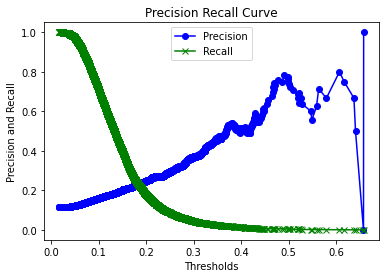

In [ ]:
prec, rec, thresh = precision_recall_curve(y_test, y_test_prob)
print(prec.shape, rec.shape, thresh.shape)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'best')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Curve')
plt.show()

(5770,) (5770,) (5770,)


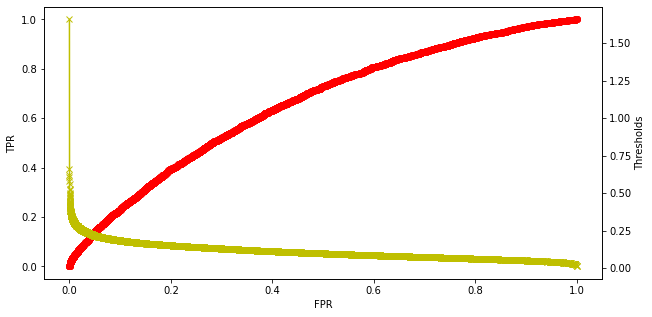

In [ ]:
fpr, tpr, thresh = roc_curve(y_test, y_test_prob)
print(fpr.shape, tpr.shape, thresh.shape)
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(fpr, tpr, marker = 'o', c = 'r')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr, thresh, marker = 'x', c = 'y')
ax1.set_ylabel('Thresholds')
plt.show()

In [ ]:
acc = []
f1 = []
prec = []
rec = []
thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in thresh:
    pred = (y_test_prob >= i).astype(bool)
    f1.append(f1_score(y_test, pred))
    acc.append(accuracy_score(y_test, pred))
    prec.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

,Thresholds,Accuracy,F1,Precision,Recall
0,0.10,0.540400,0.262020,0.160541,0.712230
1,0.15,0.750043,0.267780,0.201514,0.398981
2,0.20,0.843515,0.207892,0.247414,0.179257
3,0.25,0.871433,0.134535,0.293939,0.087230
4,0.30,0.881838,0.079700,0.369727,0.044664
5,0.35,0.884928,0.046657,0.458101,0.024580
6,0.40,0.885512,0.025716,0.511628,0.013189
7,0.45,0.885718,0.012463,0.617647,0.006295
8,0.50,0.885787,0.008939,0.750000,0.004496
9,0.55,0.885478,0.002990,0.555556,0.001499


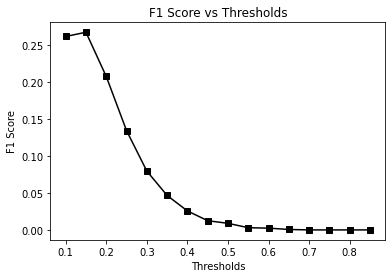

In [ ]:
plt.plot(thresh, f1, marker = 's', c = 'k')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Thresholds')
plt.show()

### With Class Weight

#### class_weight = 'balanced'

In [ ]:
imp = lgb_fi_df[lgb_fi_df['class_weight'] >= 0]['Features']
print("Number of features:", len(imp))
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, class_weight = 'balanced')
start_time = time.time()
model.fit(X_train[imp], y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train[imp])
y_train_prob = model.predict_proba(X_train[imp])[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test[imp])
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test[imp])[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Number of features: 95
Training Time: 1.3030591011047363
Prediction Time: 0.16198325157165527
Train Accuracy Score: 0.6663379887857069
Train Confusion Matrix:
 [[39748 20417]
 [ 2255  5529]] 

Train F1 Score: 0.3278387192410317
Train Precision Score: 0.21309643104910198
Train Recall Score: 0.7103031860226104
Train ROC_AUC Score: 0.757719934747789

Test Accuracy Score: 0.6412554513924659
Test Confusion Matrix:
 [[16737  9048]
 [ 1399  1937]] 

Test F1 Score: 0.2705118357656588
Test Precision Score: 0.17633136094674556
Test Recall Score: 0.5806354916067147
Test ROC_AUC Score: 0.6614694864236592


In [ ]:
imp = lgb_fi_df[lgb_fi_df['class_weight'] >= 20]['Features']
print("Number of features:", len(imp))
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, class_weight = 'balanced')
start_time = time.time()
model.fit(X_train[imp], y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train[imp])
y_train_prob = model.predict_proba(X_train[imp])[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test[imp])
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test[imp])[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Number of features: 38
Training Time: 1.0980761051177979
Prediction Time: 0.10887861251831055
Train Accuracy Score: 0.6625998910947917
Train Confusion Matrix:
 [[39545 20620]
 [ 2306  5478]] 

Train F1 Score: 0.3233575349743226
Train Precision Score: 0.20990114184995018
Train Recall Score: 0.7037512846865365
Train ROC_AUC Score: 0.7514819130911746

Test Accuracy Score: 0.6385082929844442
Test Confusion Matrix:
 [[16670  9115]
 [ 1412  1924]] 

Test F1 Score: 0.26768695652173913
Test Precision Score: 0.17429114956064862
Test Recall Score: 0.5767386091127098
Test ROC_AUC Score: 0.6586896451425248


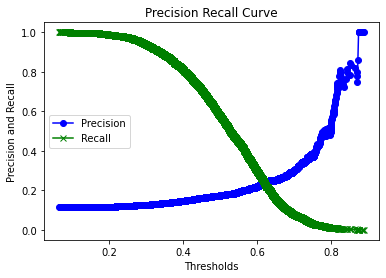

In [ ]:
prec, rec, thresh = precision_recall_curve(y_test, y_test_prob)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'best')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Curve')
plt.show()

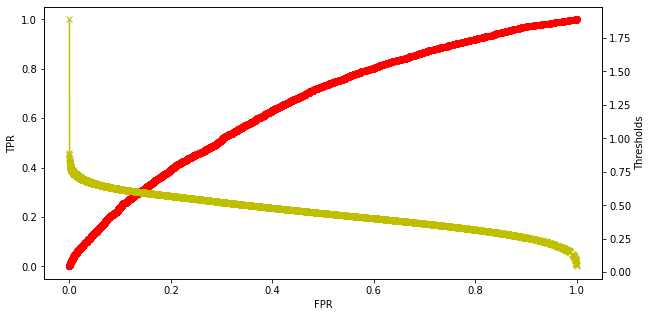

In [ ]:
fpr, tpr, thresh = roc_curve(y_test, y_test_prob)
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(fpr, tpr, marker = 'o', c = 'r')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr, thresh, marker = 'x', c = 'y')
ax1.set_ylabel('Thresholds')
plt.show()

In [ ]:
acc = []
f1 = []
prec = []
rec = []
thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in thresh:
    pred = (y_test_prob >= i).astype(bool)
    f1.append(f1_score(y_test, pred))
    acc.append(accuracy_score(y_test, pred))
    prec.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

,Thresholds,Accuracy,F1,Precision,Recall
0,0.10,0.117201,0.205759,0.114701,0.998201
1,0.15,0.125545,0.206920,0.115455,0.995803
2,0.20,0.148827,0.209976,0.117479,0.987410
3,0.25,0.190103,0.215898,0.121415,0.973321
4,0.30,0.253048,0.222921,0.126541,0.935252
5,0.35,0.339377,0.234765,0.135342,0.884592
6,0.40,0.439477,0.248584,0.146843,0.809353
7,0.45,0.545208,0.263322,0.161658,0.709532
8,0.50,0.638508,0.267687,0.174291,0.576739
9,0.55,0.721198,0.267833,0.191539,0.445144


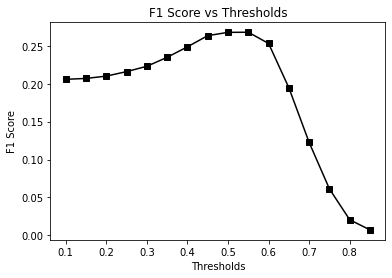

In [ ]:
plt.plot(thresh, f1, marker = 's', c = 'k')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Thresholds')
plt.show()

#### is_unbalance = True

In [ ]:
imp = lgb_fi_df[lgb_fi_df['is_unbalance'] >= 0]['Features']
print("Number of features:", len(imp))
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
start_time = time.time()
model.fit(X_train[imp], y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train[imp])
y_train_prob = model.predict_proba(X_train[imp])[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test[imp])
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test[imp])[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Number of features: 95
Training Time: 1.243466854095459
Prediction Time: 0.11866331100463867
Train Accuracy Score: 0.6641451676993039
Train Confusion Matrix:
 [[39529 20636]
 [ 2185  5599]] 

Train F1 Score: 0.3291689937975837
Train Precision Score: 0.21341719077568133
Train Recall Score: 0.7192959917780062
Train ROC_AUC Score: 0.7617999349852312

Test Accuracy Score: 0.6385082929844442
Test Confusion Matrix:
 [[16644  9141]
 [ 1386  1950]] 

Test F1 Score: 0.27032647119983366
Test Precision Score: 0.17581823099810656
Test Recall Score: 0.5845323741007195
Test ROC_AUC Score: 0.6624339562672142


In [ ]:
imp = lgb_fi_df[lgb_fi_df['is_unbalance'] >= 20]['Features']
print("Number of features:", len(imp))
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
start_time = time.time()
model.fit(X_train[imp], y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train[imp])
y_train_prob = model.predict_proba(X_train[imp])[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test[imp])
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test[imp])[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Number of features: 37
Training Time: 1.0110607147216797
Prediction Time: 0.11020183563232422
Train Accuracy Score: 0.6606866914892051
Train Confusion Matrix:
 [[39323 20842]
 [ 2214  5570]] 

Train F1 Score: 0.3257690958006784
Train Precision Score: 0.21088898985309706
Train Recall Score: 0.7155704008221994
Train ROC_AUC Score: 0.7558299593896844

Test Accuracy Score: 0.6345935922530133
Test Confusion Matrix:
 [[16518  9267]
 [ 1374  1962]] 

Test F1 Score: 0.2694129763130793
Test Precision Score: 0.17472615549024847
Test Recall Score: 0.5881294964028777
Test ROC_AUC Score: 0.6596931064804933


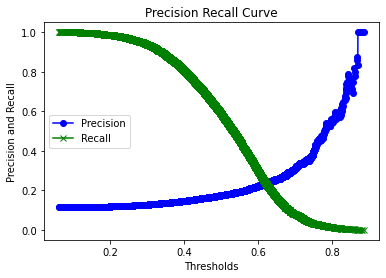

In [ ]:
prec, rec, thresh = precision_recall_curve(y_test, y_test_prob)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'best')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Curve')
plt.show()

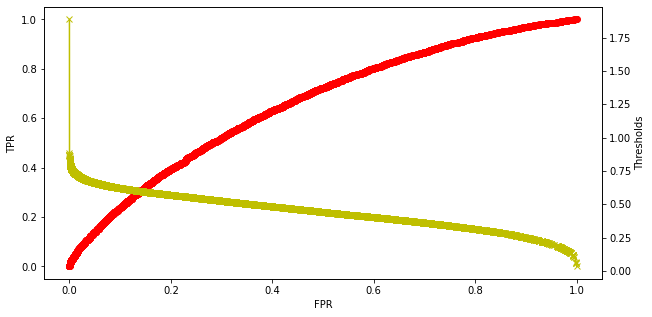

In [ ]:
fpr, tpr, thresh = roc_curve(y_test, y_test_prob)
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(fpr, tpr, marker = 'o', c = 'r')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr, thresh, marker = 'x', c = 'y')
ax1.set_ylabel('Thresholds')
plt.show()

In [ ]:
acc = []
f1 = []
prec = []
rec = []
thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in thresh:
    pred = (y_test_prob >= i).astype(bool)
    f1.append(f1_score(y_test, pred))
    acc.append(accuracy_score(y_test, pred))
    prec.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

,Thresholds,Accuracy,F1,Precision,Recall
0,0.10,0.117681,0.206093,0.114889,0.999700
1,0.15,0.129803,0.207722,0.115955,0.995803
2,0.20,0.157996,0.211474,0.118444,0.985612
3,0.25,0.199787,0.217206,0.122309,0.969125
4,0.30,0.261014,0.225286,0.128017,0.937950
5,0.35,0.342742,0.235623,0.135920,0.884293
6,0.40,0.439957,0.248121,0.146609,0.806655
7,0.45,0.540332,0.260769,0.159829,0.707734
8,0.50,0.634594,0.269413,0.174726,0.588129
9,0.55,0.720236,0.270831,0.193059,0.453537


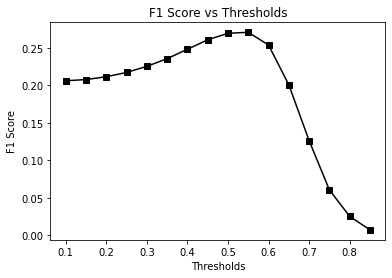

In [ ]:
plt.plot(thresh, f1, marker = 's', c = 'k')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Thresholds')
plt.show()

#### scale_pos_weight

In [ ]:
imp = lgb_fi_df[lgb_fi_df['scale_pos_weight'] >= 0]['Features']
print("Number of features:", len(imp))
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, scale_pos_weight = weight)
start_time = time.time()
model.fit(X_train[imp], y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train[imp])
y_train_prob = model.predict_proba(X_train[imp])[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test[imp])
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test[imp])[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Number of features: 95
Training Time: 1.235910177230835
Prediction Time: 0.1226506233215332
Train Accuracy Score: 0.6641451676993039
Train Confusion Matrix:
 [[39529 20636]
 [ 2185  5599]] 

Train F1 Score: 0.3291689937975837
Train Precision Score: 0.21341719077568133
Train Recall Score: 0.7192959917780062
Train ROC_AUC Score: 0.7617999349852312

Test Accuracy Score: 0.6385082929844442
Test Confusion Matrix:
 [[16644  9141]
 [ 1386  1950]] 

Test F1 Score: 0.27032647119983366
Test Precision Score: 0.17581823099810656
Test Recall Score: 0.5845323741007195
Test ROC_AUC Score: 0.6624339562672142


In [ ]:
imp = lgb_fi_df[lgb_fi_df['scale_pos_weight'] >= 20]['Features']
print("Number of features:", len(imp))
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, scale_pos_weight = weight)
start_time = time.time()
model.fit(X_train[imp], y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train[imp])
y_train_prob = model.predict_proba(X_train[imp])[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test[imp])
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test[imp])[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Number of features: 37
Training Time: 1.0172245502471924
Prediction Time: 0.10747838020324707
Train Accuracy Score: 0.6606866914892051
Train Confusion Matrix:
 [[39323 20842]
 [ 2214  5570]] 

Train F1 Score: 0.3257690958006784
Train Precision Score: 0.21088898985309706
Train Recall Score: 0.7155704008221994
Train ROC_AUC Score: 0.7558299593896844

Test Accuracy Score: 0.6345935922530133
Test Confusion Matrix:
 [[16518  9267]
 [ 1374  1962]] 

Test F1 Score: 0.2694129763130793
Test Precision Score: 0.17472615549024847
Test Recall Score: 0.5881294964028777
Test ROC_AUC Score: 0.6596931064804933


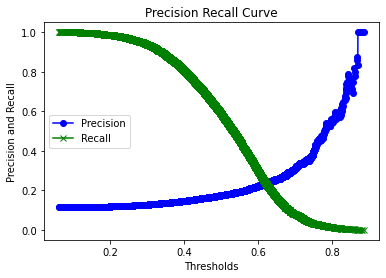

In [ ]:
prec, rec, thresh = precision_recall_curve(y_test, y_test_prob)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'best')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Curve')
plt.show()

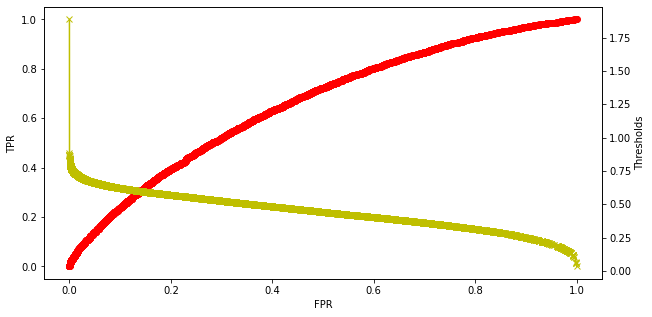

In [ ]:
fpr, tpr, thresh = roc_curve(y_test, y_test_prob)
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(fpr, tpr, marker = 'o', c = 'r')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr, thresh, marker = 'x', c = 'y')
ax1.set_ylabel('Thresholds')
plt.show()

In [ ]:
acc = []
f1 = []
prec = []
rec = []
thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in thresh:
    pred = (y_test_prob >= i).astype(bool)
    f1.append(f1_score(y_test, pred))
    acc.append(accuracy_score(y_test, pred))
    prec.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

,Thresholds,Accuracy,F1,Precision,Recall
0,0.10,0.117681,0.206093,0.114889,0.999700
1,0.15,0.129803,0.207722,0.115955,0.995803
2,0.20,0.157996,0.211474,0.118444,0.985612
3,0.25,0.199787,0.217206,0.122309,0.969125
4,0.30,0.261014,0.225286,0.128017,0.937950
5,0.35,0.342742,0.235623,0.135920,0.884293
6,0.40,0.439957,0.248121,0.146609,0.806655
7,0.45,0.540332,0.260769,0.159829,0.707734
8,0.50,0.634594,0.269413,0.174726,0.588129
9,0.55,0.720236,0.270831,0.193059,0.453537


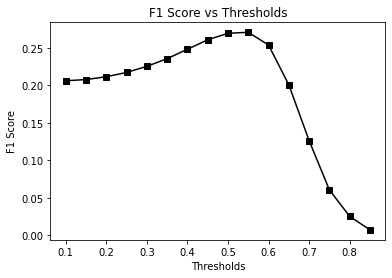

In [ ]:
plt.plot(thresh, f1, marker = 's', c = 'k')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Thresholds')
plt.show()

### Trying with reducing diag categories

In [ ]:
X.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,glyburide-metformin,diabetesMed,preceding_year_visits,number_changes,insulin_treatment
0,Caucasian,0,5,Not Available,Referral,1,41,0,1,Diabetes,Not Required,Not Required,1,None,None,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,no_med
1,Caucasian,0,15,Discharged to home,Emergency,3,59,0,18,"Endocrine, Nutritional, Metabolic, Immunity",Diabetes,"Endocrine, Nutritional, Metabolic, Immunity",9,None,None,-2,-2,-2,-2,-2,-2,-2,-2,1,-2,1,0,1,insulin_only
2,AfricanAmerican,0,25,Discharged to home,Emergency,2,11,5,13,"Pregnancy, Childbirth",Diabetes,External causes of injury,6,None,None,-2,-2,-2,-2,0,-2,-2,-2,-2,-2,1,3,0,other_meds
3,Caucasian,1,35,Discharged to home,Emergency,2,44,1,16,Infectious and Parasitic,Diabetes,Circulatory,7,None,None,-2,-2,-2,-2,-2,-2,-2,-2,1,-2,1,0,1,insulin_only
4,Caucasian,1,45,Discharged to home,Emergency,1,51,0,8,Neoplasms,Neoplasms,Diabetes,5,None,None,-2,-2,-2,-2,0,-2,-2,-2,0,-2,1,0,0,insulin_combo


In [ ]:
X['diag_1'].value_counts(1)

Circulatory                                     0.298795
Respiratory                                     0.140352
Digestive                                       0.094303
Diabetes                                        0.087267
Injury and Poisoning                            0.069012
Genitourinary                                   0.050603
Musculoskeletal System and Connective Tissue    0.049459
Neoplasms                                       0.029803
Endocrine, Nutritional, Metabolic, Immunity     0.026301
Skin and Subcutaneous Tissue                    0.026125
Infectious and Parasitic                        0.025621
Other Symptoms                                  0.025487
Mental Disorders                                0.022396
External causes of injury                       0.016431
Blood and Blood-Forming Organs                  0.011105
Nervous                                         0.009292
Congenital Anomalies                            0.008149
Pregnancy, Childbirth          

In [ ]:
X_1 = X.copy()

In [ ]:
X_1['diag_1'] = X_1['diag_1'].map({'Circulatory' : 'Circulatory',
                                   'Respiratory' : 'Respiratory',
                                   'Digestive' : 'Digestive',
                                   'Diabetes' : 'Diabetes',
                                   'Injury and Poisoning' : 'Injury and Poisoning',
                                   'Genitourinary' : 'Genitourinary',
                                   'Musculoskeletal System and Connective Tissue' : 'Musculoskeletal System and Connective Tissue',
                                   'Neoplasms' : 'Others',
                                   'Endocrine, Nutritional, Metabolic, Immunity' : 'Others',
                                   'Skin and Subcutaneous Tissue' : 'Others',
                                   'Infectious and Parasitic' : 'Others',
                                   'Other Symptoms' : 'Others',
                                   'Mental Disorders' : 'Others',
                                   'External causes of injury' : 'Others',
                                   'Blood and Blood-Forming Organs' : 'Others',
                                   'Nervous' : 'Others',
                                   'Congenital Anomalies' : 'Others',
                                   'Pregnancy, Childbirth' : 'Others',
                                   'Sense Organs' : 'Others'})

In [ ]:
X_1['diag_1'].value_counts(1)

Circulatory                                     0.298795
Others                                          0.210209
Respiratory                                     0.140352
Digestive                                       0.094303
Diabetes                                        0.087267
Injury and Poisoning                            0.069012
Genitourinary                                   0.050603
Musculoskeletal System and Connective Tissue    0.049459
Name: diag_1, dtype: float64

In [ ]:
X_1['diag_2'] = X_1['diag_2'].map({'Circulatory' : 'Circulatory',
                                   'Respiratory' : 'Respiratory',
                                   'Digestive' : 'Digestive',
                                   'Diabetes' : 'Diabetes',
                                   'Injury and Poisoning' : 'Injury and Poisoning',
                                   'Genitourinary' : 'Genitourinary',
                                   'Musculoskeletal System and Connective Tissue' : 'Musculoskeletal System and Connective Tissue',
                                   'Neoplasms' : 'Others',
                                   'Endocrine, Nutritional, Metabolic, Immunity' : 'Others',
                                   'Skin and Subcutaneous Tissue' : 'Others',
                                   'Infectious and Parasitic' : 'Others',
                                   'Other Symptoms' : 'Others',
                                   'Mental Disorders' : 'Others',
                                   'External causes of injury' : 'Others',
                                   'Blood and Blood-Forming Organs' : 'Others',
                                   'Nervous' : 'Others',
                                   'Congenital Anomalies' : 'Others',
                                   'Pregnancy, Childbirth' : 'Others',
                                   'Sense Organs' : 'Others',
                                   'Not Required' : 'Not Required'})

In [ ]:
X_1['diag_3'] = X_1['diag_3'].map({'Circulatory' : 'Circulatory',
                                   'Respiratory' : 'Respiratory',
                                   'Digestive' : 'Digestive',
                                   'Diabetes' : 'Diabetes',
                                   'Injury and Poisoning' : 'Injury and Poisoning',
                                   'Genitourinary' : 'Genitourinary',
                                   'Musculoskeletal System and Connective Tissue' : 'Musculoskeletal System and Connective Tissue',
                                   'Neoplasms' : 'Others',
                                   'Endocrine, Nutritional, Metabolic, Immunity' : 'Others',
                                   'Skin and Subcutaneous Tissue' : 'Others',
                                   'Infectious and Parasitic' : 'Others',
                                   'Other Symptoms' : 'Others',
                                   'Mental Disorders' : 'Others',
                                   'External causes of injury' : 'Others',
                                   'Blood and Blood-Forming Organs' : 'Others',
                                   'Nervous' : 'Others',
                                   'Congenital Anomalies' : 'Others',
                                   'Pregnancy, Childbirth' : 'Others',
                                   'Sense Organs' : 'Others',
                                   'Not Required' : 'Not Required'})

In [ ]:
X_1.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,glyburide-metformin,diabetesMed,preceding_year_visits,number_changes,insulin_treatment
0,Caucasian,0,5,Not Available,Referral,1,41,0,1,Diabetes,Not Required,Not Required,1,None,None,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,no_med
1,Caucasian,0,15,Discharged to home,Emergency,3,59,0,18,Others,Diabetes,Others,9,None,None,-2,-2,-2,-2,-2,-2,-2,-2,1,-2,1,0,1,insulin_only
2,AfricanAmerican,0,25,Discharged to home,Emergency,2,11,5,13,Others,Diabetes,Others,6,None,None,-2,-2,-2,-2,0,-2,-2,-2,-2,-2,1,3,0,other_meds
3,Caucasian,1,35,Discharged to home,Emergency,2,44,1,16,Others,Diabetes,Circulatory,7,None,None,-2,-2,-2,-2,-2,-2,-2,-2,1,-2,1,0,1,insulin_only
4,Caucasian,1,45,Discharged to home,Emergency,1,51,0,8,Others,Others,Diabetes,5,None,None,-2,-2,-2,-2,0,-2,-2,-2,0,-2,1,0,0,insulin_combo


In [ ]:
X_1.isna().sum()

race                        0
gender                      0
age                         0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
glimepiride                 0
glipizide                   0
glyburide                   0
pioglitazone                0
rosiglitazone               0
insulin                     0
glyburide-metformin         0
diabetesMed                 0
preceding_year_visits       0
number_changes              0
insulin_treatment           0
dtype: int64

In [ ]:
X_1_dum = pd.get_dummies(X_1, drop_first = True)

In [ ]:
X_1_dum.shape

(97070, 64)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_1_dum, y, test_size = 0.3, random_state = 0, stratify = y)
lgb = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
lgb.fit(X_train, y_train)
fi_df = pd.DataFrame({'Features' : X_train.columns, 'Importances' : lgb.feature_importances_})
sorted(zip(lgb.feature_importances_, X_train.columns), reverse = True)

[(453, 'num_lab_procedures'),
 (364, 'num_medications'),
 (217, 'time_in_hospital'),
 (180, 'age'),
 (167, 'preceding_year_visits'),
 (151, 'number_diagnoses'),
 (132, 'num_procedures'),
 (73, 'insulin'),
 (58, 'metformin'),
 (52, 'admission_source_id_Referral'),
 (51, 'discharge_disposition_id_Transferred to another medical facility'),
 (49, 'gender'),
 (49, 'diag_1_Respiratory'),
 (44, 'discharge_disposition_id_Discharged to home with home health service'),
 (44, 'diag_3_Others'),
 (41, 'glipizide'),
 (37, 'race_Caucasian'),
 (36, 'glyburide'),
 (35, 'diag_2_Respiratory'),
 (34, 'diag_3_Diabetes'),
 (33, 'diabetesMed'),
 (32, 'insulin_treatment_insulin_only'),
 (32, 'diag_2_Diabetes'),
 (31, 'diag_2_Others'),
 (31, 'diag_1_Others'),
 (31, 'A1Cresult_None'),
 (28, 'number_changes'),
 (27, 'admission_source_id_Transferred from another health care facility'),
 (26, 'discharge_disposition_id_Not Available'),
 (26, 'A1Cresult_>8'),
 (25, 'diag_3_Respiratory'),
 (24, 'diag_1_Diabetes'),
 (

In [ ]:
imp = fi_df[fi_df['Importances'] >= 25]['Features']
print("Number of features:", len(imp))
lgb1 = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
lgb1.fit(X_train[imp], y_train)
pred = lgb1.predict(X_test[imp])
prob = lgb1.predict_proba(X_test[imp])[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

Number of features: 31
[[16663  9122]
 [ 1407  1929]]
              precision    recall  f1-score   support

           0       0.92      0.65      0.76     25785
           1       0.17      0.58      0.27      3336

    accuracy                           0.64     29121
   macro avg       0.55      0.61      0.51     29121
weighted avg       0.84      0.64      0.70     29121

ROC_AUC: 0.65319621556972


### Sampling Techniques

#### Under Sampling

In [ ]:
rus = RandomUnderSampler(random_state = 0)
X_rus, y_rus = rus.fit_resample(X_train[imp], y_train)
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1)
model.fit(X_rus, y_rus)
pred = model.predict(X_test[imp])
prob = model.predict_proba(X_test[imp])[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[15307 10478]
 [ 1241  2095]]
              precision    recall  f1-score   support

           0       0.93      0.59      0.72     25785
           1       0.17      0.63      0.26      3336

    accuracy                           0.60     29121
   macro avg       0.55      0.61      0.49     29121
weighted avg       0.84      0.60      0.67     29121

ROC_AUC: 0.6497984858186748


In [ ]:
rus = RandomUnderSampler(random_state = 0)
X_rus, y_rus = rus.fit_resample(X_train[imp], y_train)
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
model.fit(X_rus, y_rus)
pred = model.predict(X_test[imp])
prob = model.predict_proba(X_test[imp])[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[15307 10478]
 [ 1241  2095]]
              precision    recall  f1-score   support

           0       0.93      0.59      0.72     25785
           1       0.17      0.63      0.26      3336

    accuracy                           0.60     29121
   macro avg       0.55      0.61      0.49     29121
weighted avg       0.84      0.60      0.67     29121

ROC_AUC: 0.6497984858186748


#### Over Sampling

In [ ]:
ros = RandomOverSampler(random_state = 0)
X_ros, y_ros = ros.fit_resample(X_train[imp], y_train)
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1)
model.fit(X_ros, y_ros)
pred = model.predict(X_test[imp])
prob = model.predict_proba(X_test[imp])[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[16666  9119]
 [ 1434  1902]]
              precision    recall  f1-score   support

           0       0.92      0.65      0.76     25785
           1       0.17      0.57      0.26      3336

    accuracy                           0.64     29121
   macro avg       0.55      0.61      0.51     29121
weighted avg       0.84      0.64      0.70     29121

ROC_AUC: 0.6543104492554881


In [ ]:
ros = RandomOverSampler(random_state = 0)
X_ros, y_ros = ros.fit_resample(X_train[imp], y_train)
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
model.fit(X_ros, y_ros)
pred = model.predict(X_test[imp])
prob = model.predict_proba(X_test[imp])[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[16666  9119]
 [ 1434  1902]]
              precision    recall  f1-score   support

           0       0.92      0.65      0.76     25785
           1       0.17      0.57      0.26      3336

    accuracy                           0.64     29121
   macro avg       0.55      0.61      0.51     29121
weighted avg       0.84      0.64      0.70     29121

ROC_AUC: 0.6543104492554881


#### SMOTE

In [ ]:
sm = SMOTE(random_state = 0, n_jobs = -1)
X_sm, y_sm = sm.fit_resample(X_train[imp], y_train)
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1)
model.fit(X_sm, y_sm)
pred = model.predict(X_test[imp])
prob = model.predict_proba(X_test[imp])[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[22907  2878]
 [ 2898   438]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     25785
           1       0.13      0.13      0.13      3336

    accuracy                           0.80     29121
   macro avg       0.51      0.51      0.51     29121
weighted avg       0.80      0.80      0.80     29121

ROC_AUC: 0.5547568693154842


In [ ]:
sm = SMOTE(random_state = 0, n_jobs = -1)
X_sm, y_sm = sm.fit_resample(X_train[imp], y_train)
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
model.fit(X_sm, y_sm)
pred = model.predict(X_test[imp])
prob = model.predict_proba(X_test[imp])[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[22907  2878]
 [ 2898   438]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     25785
           1       0.13      0.13      0.13      3336

    accuracy                           0.80     29121
   macro avg       0.51      0.51      0.51     29121
weighted avg       0.80      0.80      0.80     29121

ROC_AUC: 0.5547568693154842


#### SmoteTomek

In [ ]:
smtmk = SMOTETomek(random_state = 0)
X_smtmk, y_smtmk = sm.fit_resample(X_train[imp], y_train)
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1)
model.fit(X_smtmk, y_smtmk)
pred = model.predict(X_test[imp])
prob = model.predict_proba(X_test[imp])[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[22907  2878]
 [ 2898   438]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     25785
           1       0.13      0.13      0.13      3336

    accuracy                           0.80     29121
   macro avg       0.51      0.51      0.51     29121
weighted avg       0.80      0.80      0.80     29121

ROC_AUC: 0.5547568693154842


In [ ]:
smtmk = SMOTETomek(random_state = 0)
X_smtmk, y_smtmk = sm.fit_resample(X_train[imp], y_train)
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
model.fit(X_smtmk, y_smtmk)
pred = model.predict(X_test[imp])
prob = model.predict_proba(X_test[imp])[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[[22907  2878]
 [ 2898   438]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     25785
           1       0.13      0.13      0.13      3336

    accuracy                           0.80     29121
   macro avg       0.51      0.51      0.51     29121
weighted avg       0.80      0.80      0.80     29121

ROC_AUC: 0.5547568693154842


### Hyper-Parameter Tuning

In [ ]:
X_train.shape, y_train.sum()

((67949, 97), 7784)

In [ ]:
np.logspace(-2, 0, 100)

array([0.01      , 0.01047616, 0.01097499, 0.01149757, 0.01204504,
       0.01261857, 0.01321941, 0.01384886, 0.01450829, 0.01519911,
       0.01592283, 0.01668101, 0.01747528, 0.01830738, 0.0191791 ,
       0.02009233, 0.02104904, 0.02205131, 0.0231013 , 0.02420128,
       0.02535364, 0.02656088, 0.02782559, 0.02915053, 0.03053856,
       0.03199267, 0.03351603, 0.03511192, 0.0367838 , 0.03853529,
       0.04037017, 0.04229243, 0.04430621, 0.04641589, 0.04862602,
       0.05094138, 0.05336699, 0.0559081 , 0.05857021, 0.06135907,
       0.06428073, 0.06734151, 0.07054802, 0.07390722, 0.07742637,
       0.08111308, 0.08497534, 0.08902151, 0.09326033, 0.097701  ,
       0.1023531 , 0.10722672, 0.1123324 , 0.1176812 , 0.12328467,
       0.12915497, 0.13530478, 0.14174742, 0.14849683, 0.15556761,
       0.16297508, 0.17073526, 0.17886495, 0.18738174, 0.19630407,
       0.20565123, 0.21544347, 0.22570197, 0.23644894, 0.24770764,
       0.25950242, 0.27185882, 0.28480359, 0.29836472, 0.31257

In [ ]:
np.linspace(0.01, 1, 100)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

In [ ]:
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)

params = {'boosting_type' : ['gbdt', 'dart', 'goss', 'rf'],
          'num_leaves' : np.arange(15, 60),
          'max_depth' : np.arange(1, 100),
          'learning_rate' : np.linspace(0.01, 1, 100),
          'n_estimators' : np.arange(100, 1000),
          'min_child_samples' : np.arange(10, 40)}

rsearch = RandomizedSearchCV(model, params, n_iter = 25, scoring = 'roc_auc', n_jobs = -1,
                             cv = 3, verbose = 1, random_state = 0)
rsearch.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 17.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            is_unbalance=True,
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective='binary',
                                            random_state=0, reg_alpha=0.0,...
       971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983,
       984, 985, 986, 987, 988, 989, 990, 991, 992, 99

In [ ]:
print("Best ROC_AUC : ", rsearch.best_score_)
rsearch.best_params_

Best ROC_AUC :  0.6476433630090365


{'boosting_type': 'dart',
 'learning_rate': 0.14,
 'max_depth': 77,
 'min_child_samples': 26,
 'n_estimators': 104,
 'num_leaves': 49}

In [ ]:
model = rsearch.best_estimator_
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test)[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Training Time: 4.32855486869812
Prediction Time: 0.17628049850463867
Train Accuracy Score: 0.6571104799187626
Train Confusion Matrix:
 [[38987 21178]
 [ 2121  5663]] 

Train F1 Score: 0.32710469314079427
Train Precision Score: 0.21098319734734175
Train Recall Score: 0.7275179856115108
Train ROC_AUC Score: 0.7575203476496504

Test Accuracy Score: 0.6334947288898046
Test Confusion Matrix:
 [[16449  9336]
 [ 1337  1999]] 

Test F1 Score: 0.2725103946561243
Test Precision Score: 0.17635641817379796
Test Recall Score: 0.5992206235011991
Test ROC_AUC Score: 0.6629010520495762


In [ ]:
np.linspace(0.014, 1.4, 50)

array([0.014     , 0.04228571, 0.07057143, 0.09885714, 0.12714286,
       0.15542857, 0.18371429, 0.212     , 0.24028571, 0.26857143,
       0.29685714, 0.32514286, 0.35342857, 0.38171429, 0.41      ,
       0.43828571, 0.46657143, 0.49485714, 0.52314286, 0.55142857,
       0.57971429, 0.608     , 0.63628571, 0.66457143, 0.69285714,
       0.72114286, 0.74942857, 0.77771429, 0.806     , 0.83428571,
       0.86257143, 0.89085714, 0.91914286, 0.94742857, 0.97571429,
       1.004     , 1.03228571, 1.06057143, 1.08885714, 1.11714286,
       1.14542857, 1.17371429, 1.202     , 1.23028571, 1.25857143,
       1.28685714, 1.31514286, 1.34342857, 1.37171429, 1.4       ])

In [ ]:
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)

params = {'boosting_type' : ['gbdt', 'dart', 'goss', 'rf'],
          'num_leaves' : np.arange(25, 100),
          'max_depth' : np.arange(40, 160),
          'learning_rate' : np.linspace(0.01, 1, 50),
          'n_estimators' : np.arange(52, 208),
          'min_child_samples' : np.arange(13, 52)}

rsearch = RandomizedSearchCV(model, params, n_iter = 50, scoring = 'roc_auc', n_jobs = -1,
                             cv = 5, verbose = 1, random_state = 0)
rsearch.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            is_unbalance=True,
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective='binary',
                                            random_state=0, reg_alpha=0.0,...
                                        'num_leaves': array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4

In [ ]:
print("Best ROC_AUC : ", rsearch.best_score_)
rsearch.best_params_

Best ROC_AUC :  0.6533633714674332


{'boosting_type': 'goss',
 'learning_rate': 0.07061224489795918,
 'max_depth': 152,
 'min_child_samples': 18,
 'n_estimators': 84,
 'num_leaves': 33}

In [ ]:
model = rsearch.best_estimator_
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test)[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Training Time: 1.3424479961395264
Prediction Time: 0.13700151443481445
Train Accuracy Score: 0.6421875229951876
Train Confusion Matrix:
 [[38169 21996]
 [ 2317  5467]] 

Train F1 Score: 0.3102107980821062
Train Precision Score: 0.1990678367257765
Train Recall Score: 0.7023381294964028
Train ROC_AUC Score: 0.7324876534289183

Test Accuracy Score: 0.6265238144294495
Test Confusion Matrix:
 [[16225  9560]
 [ 1316  2020]] 

Test F1 Score: 0.27085009385894343
Test Precision Score: 0.17443868739205526
Test Recall Score: 0.605515587529976
Test ROC_AUC Score: 0.6641936247395337


In [ ]:
np.linspace(0.007, 0.7, 25)

array([0.007   , 0.035875, 0.06475 , 0.093625, 0.1225  , 0.151375,
       0.18025 , 0.209125, 0.238   , 0.266875, 0.29575 , 0.324625,
       0.3535  , 0.382375, 0.41125 , 0.440125, 0.469   , 0.497875,
       0.52675 , 0.555625, 0.5845  , 0.613375, 0.64225 , 0.671125,
       0.7     ])

In [ ]:
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)

params = {'boosting_type' : ['gbdt', 'dart', 'goss', 'rf'],
          'num_leaves' : np.arange(15, 60),
          'max_depth' : np.arange(75, 300),
          'learning_rate' : np.linspace(0.007, 0.7, 25),
          'n_estimators' : np.arange(40, 160),
          'min_child_samples' : np.arange(9, 36)}

rsearch = RandomizedSearchCV(model, params, n_iter = 100, scoring = 'roc_auc', n_jobs = -1,
                             cv = 10, verbose = 1, random_state = 0)
rsearch.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 18.5min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            is_unbalance=True,
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective='binary',
                                            random_state=0, reg_alpha=0.0...
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 15

In [ ]:
print("Best ROC_AUC : ", rsearch.best_score_)
rsearch.best_params_

Best ROC_AUC :  0.6538734388367365


{'boosting_type': 'gbdt',
 'learning_rate': 0.06475,
 'max_depth': 178,
 'min_child_samples': 22,
 'n_estimators': 128,
 'num_leaves': 23}

In [ ]:
model = rsearch.best_estimator_
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test)[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Training Time: 1.5528984069824219
Prediction Time: 0.14951324462890625
Train Accuracy Score: 0.6409807355516638
Train Confusion Matrix:
 [[38185 21980]
 [ 2415  5369]] 

Train F1 Score: 0.3056385734210002
Train Precision Score: 0.19631430765293065
Train Recall Score: 0.689748201438849
Train ROC_AUC Score: 0.7271132127314497

Test Accuracy Score: 0.6275539988324577
Test Confusion Matrix:
 [[16249  9536]
 [ 1310  2026]] 

Test F1 Score: 0.2719828164854343
Test Precision Score: 0.17522919910050164
Test Recall Score: 0.6073141486810552
Test ROC_AUC Score: 0.6643060130139053


In [ ]:
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True,
                       boosting_type = 'gbdt', learning_rate = 0.06475, max_depth = 178,
                       min_child_samples = 22, n_estimators = 128, num_leaves = 23)
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test)[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Training Time: 1.549548864364624
Prediction Time: 0.14243340492248535
Train Accuracy Score: 0.6409807355516638
Train Confusion Matrix:
 [[38185 21980]
 [ 2415  5369]] 

Train F1 Score: 0.3056385734210002
Train Precision Score: 0.19631430765293065
Train Recall Score: 0.689748201438849
Train ROC_AUC Score: 0.7271132127314497

Test Accuracy Score: 0.6275539988324577
Test Confusion Matrix:
 [[16249  9536]
 [ 1310  2026]] 

Test F1 Score: 0.2719828164854343
Test Precision Score: 0.17522919910050164
Test Recall Score: 0.6073141486810552
Test ROC_AUC Score: 0.6643060130139053


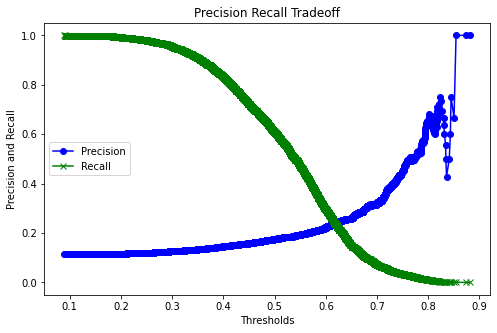

In [ ]:
plt.figure(figsize = (8, 5))
prec, rec, thresh = precision_recall_curve(y_test, y_test_prob)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'center left')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Tradeoff')
plt.show()

Best Threshold=0.487070, G-Mean=0.621


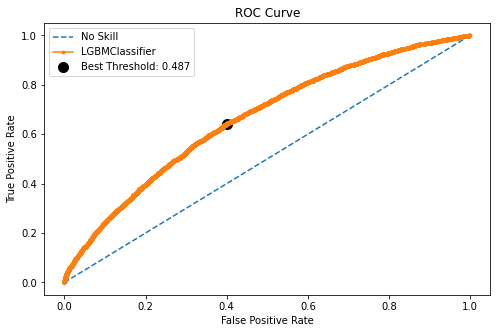

In [ ]:
plt.figure(figsize = (8, 5))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LGBMClassifier')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', alpha = 1, edgecolors = 'k', s = 100,
            label='Best Threshold: '+str(round(thresholds[ix], 3)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend(loc = 'best')
# show the plot
plt.show()

In [ ]:
acc = []
f1 = []
prec = []
rec = []
thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in thresh:
    pred = (y_test_prob >= i).astype(bool)
    f1.append(f1_score(y_test, pred))
    acc.append(accuracy_score(y_test, pred))
    prec.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

,Thresholds,Accuracy,F1,Precision,Recall
0,0.10,0.117029,0.205874,0.114761,0.999101
1,0.15,0.122043,0.206610,0.115234,0.997902
2,0.20,0.138113,0.208658,0.116592,0.991906
3,0.25,0.173929,0.213702,0.119928,0.979916
4,0.30,0.234333,0.222315,0.125794,0.955336
5,0.35,0.315820,0.233220,0.133787,0.908273
6,0.40,0.421792,0.247766,0.145580,0.831235
7,0.45,0.528897,0.260072,0.158566,0.722722
8,0.50,0.627554,0.271983,0.175229,0.607314
9,0.55,0.714193,0.273925,0.193183,0.470624


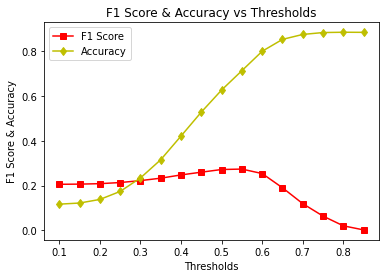

In [ ]:
plt.plot(thresh, f1, marker = 's', c = 'r', label = 'F1 Score')
plt.plot(thresh, acc, marker = 'd', c = 'y', label = 'Accuracy')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score & Accuracy')
plt.title('F1 Score & Accuracy vs Thresholds')
plt.legend(loc = 'best')
plt.show()

In [ ]:
y_train_pred = (y_train_prob >= 0.487).astype(bool)
y_test_pred = (y_test_prob >= 0.487).astype(bool)
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Train Accuracy Score: 0.6173453619626484
Train Confusion Matrix:
 [[36343 23822]
 [ 2179  5605]] 

Train F1 Score: 0.3012550052403859
Train Precision Score: 0.19047133584803072
Train Recall Score: 0.7200668036998972
Train ROC_AUC Score: 0.7271132127314497

Test Accuracy Score: 0.6047525840458775
Test Confusion Matrix:
 [[15466 10319]
 [ 1191  2145]] 

Test F1 Score: 0.27151898734177216
Test Precision Score: 0.1720956354300385
Test Recall Score: 0.6429856115107914
Test ROC_AUC Score: 0.6643060130139053


In [ ]:
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True, silent = False)
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
params = {'num_leaves' : np.arange(10, 40),
          'max_depth' : np.arange(90, 360),
          'learning_rate' : np.linspace(0.006, 0.6, 25),
          'n_estimators' : np.arange(64, 256),
          'min_child_samples' : np.arange(11, 44),
          'subsample' : np.linspace(0.5, 1, 11),
          'colsample_bytree' : np.linspace(0.5, 1, 11),
          'reg_alpha' : [0, 1e-5, 5e-5, 1e-4, 5e-4, 0.001, 0.005,
                         0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
          'reg_lambda' : [0, 1e-5, 5e-5, 1e-4, 5e-4, 0.001, 0.005,
                         0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
          'subsample_freq' : [0, 1, 2, 3, 4, 5]}

rsearch = RandomizedSearchCV(model, params, n_iter = 50, scoring = 'roc_auc', n_jobs = -1,
                             cv = cv, verbose = 2, random_state = 0)
rsearch.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.9min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            is_unbalance=True,
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leav...
                                        'reg_alpha': [0, 1e-05, 5e-05, 0.0001,
                                                      0.0005, 0.001, 0.00

In [ ]:
print("Best ROC_AUC : ", rsearch.best_score_)
rsearch.best_params_

Best ROC_AUC :  0.6540053616458693


{'colsample_bytree': 0.7,
 'learning_rate': 0.055499999999999994,
 'max_depth': 309,
 'min_child_samples': 28,
 'n_estimators': 180,
 'num_leaves': 31,
 'reg_alpha': 50,
 'reg_lambda': 5,
 'subsample': 0.7,
 'subsample_freq': 2}

In [ ]:
model = rsearch.best_estimator_
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test)[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Training Time: 2.602647304534912
Prediction Time: 0.34842872619628906
Train Accuracy Score: 0.6254838187464128
Train Confusion Matrix:
 [[37360 22805]
 [ 2643  5141]] 

Train F1 Score: 0.28776938147215225
Train Precision Score: 0.18396192657267588
Train Recall Score: 0.6604573484069887
Train ROC_AUC Score: 0.6970697072003686

Test Accuracy Score: 0.6207891212527042
Test Confusion Matrix:
 [[16016  9769]
 [ 1274  2062]] 

Test F1 Score: 0.27190611195358344
Test Precision Score: 0.17428788775251458
Test Recall Score: 0.61810551558753
Test ROC_AUC Score: 0.6658753916006229


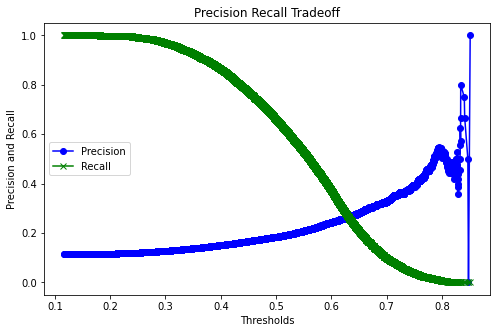

In [ ]:
plt.figure(figsize = (8, 5))
prec, rec, thresh = precision_recall_curve(y_train, y_train_prob)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'center left')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Tradeoff')
plt.show()

Best Threshold=0.495109, G-Mean=0.641


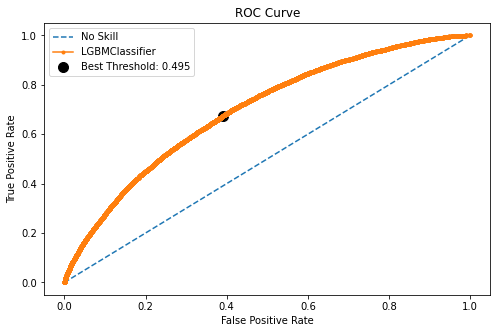

In [ ]:
plt.figure(figsize = (8, 5))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, y_train_prob)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_thresh = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_thresh, gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LGBMClassifier')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', alpha = 1, edgecolors = 'k', s = 100,
            label='Best Threshold: '+str(round(best_thresh, 3)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend(loc = 'best')
# show the plot
plt.show()

In [ ]:
acc = []
f1 = []
prec = []
rec = []
thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in thresh:
    pred = (y_test_prob >= i).astype(bool)
    f1.append(f1_score(y_test, pred))
    acc.append(accuracy_score(y_test, pred))
    prec.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

,Thresholds,Accuracy,F1,Precision,Recall
0,0.10,0.114591,0.205571,0.114560,1.000000
1,0.15,0.116686,0.205909,0.114774,0.999700
2,0.20,0.130765,0.208004,0.116122,0.996403
3,0.25,0.168538,0.213072,0.119491,0.982614
4,0.30,0.235191,0.222564,0.125948,0.955635
5,0.35,0.319872,0.233751,0.134195,0.905576
6,0.40,0.422444,0.248850,0.146208,0.835132
7,0.45,0.523780,0.260452,0.158407,0.732014
8,0.50,0.620789,0.271906,0.174288,0.618106
9,0.55,0.710106,0.274119,0.192187,0.477818


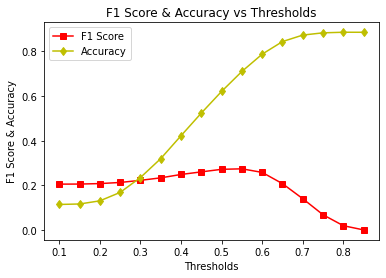

In [ ]:
plt.plot(thresh, f1, marker = 's', c = 'r', label = 'F1 Score')
plt.plot(thresh, acc, marker = 'd', c = 'y', label = 'Accuracy')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score & Accuracy')
plt.title('F1 Score & Accuracy vs Thresholds')
plt.legend(loc = 'best')
plt.show()

In [ ]:
y_train_pred = (y_train_prob >= best_thresh).astype(bool)
y_test_pred = (y_test_prob >= best_thresh).astype(bool)
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Train Accuracy Score: 0.6168744205212733
Train Confusion Matrix:
 [[36668 23497]
 [ 2536  5248]] 

Train F1 Score: 0.28733335158367324
Train Precision Score: 0.18257088189250303
Train Recall Score: 0.6742034943473793
Train ROC_AUC Score: 0.6970697072003686

Test Accuracy Score: 0.6115861405858315
Test Confusion Matrix:
 [[15694 10091]
 [ 1220  2116]] 

Test F1 Score: 0.27227690921958436
Test Precision Score: 0.17334316375849923
Test Recall Score: 0.6342925659472423
Test ROC_AUC Score: 0.6658753916006229


In [ ]:
np.linspace(10, 100, 100)

array([ 10.        ,  10.90909091,  11.81818182,  12.72727273,
        13.63636364,  14.54545455,  15.45454545,  16.36363636,
        17.27272727,  18.18181818,  19.09090909,  20.        ,
        20.90909091,  21.81818182,  22.72727273,  23.63636364,
        24.54545455,  25.45454545,  26.36363636,  27.27272727,
        28.18181818,  29.09090909,  30.        ,  30.90909091,
        31.81818182,  32.72727273,  33.63636364,  34.54545455,
        35.45454545,  36.36363636,  37.27272727,  38.18181818,
        39.09090909,  40.        ,  40.90909091,  41.81818182,
        42.72727273,  43.63636364,  44.54545455,  45.45454545,
        46.36363636,  47.27272727,  48.18181818,  49.09090909,
        50.        ,  50.90909091,  51.81818182,  52.72727273,
        53.63636364,  54.54545455,  55.45454545,  56.36363636,
        57.27272727,  58.18181818,  59.09090909,  60.        ,
        60.90909091,  61.81818182,  62.72727273,  63.63636364,
        64.54545455,  65.45454545,  66.36363636,  67.27

In [ ]:
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 0)
params = {'colsample_bytree' : np.linspace(0.55, 0.95, 9),
          'learning_rate' : np.linspace(0.005, 0.5, 100),
          'max_depth' : np.arange(150, 600),
          'min_child_samples' : np.arange(14, 56),
          'n_estimators' : np.arange(90, 360),
          'num_leaves' : np.arange(15, 60),
          'reg_alpha' : np.linspace(10, 100, 100),
          'reg_lambda' : np.linspace(1, 10, 100),          
          'subsample' : np.linspace(0.55, 0.95, 9),
          'subsample_freq' : [0, 1, 2, 3, 4]}

rsearch = RandomizedSearchCV(model, params, n_iter = 100, scoring = 'roc_auc', n_jobs = -1,
                             cv = cv, verbose = 3, random_state = 0)
rsearch.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 36.6min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            is_unbalance=True,
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_lea...
        8.27272727,  8.36363636,  8.45454545,  8.54545455,  8.63636364,
        8.72727273,  8.81818182,  8.90909091,  9.        ,  9.09090909,
        

In [ ]:
print("Best ROC_AUC : ", rsearch.best_score_)
rsearch.best_params_

Best ROC_AUC :  0.6565358372077781


{'colsample_bytree': 0.65,
 'learning_rate': 0.025,
 'max_depth': 569,
 'min_child_samples': 47,
 'n_estimators': 304,
 'num_leaves': 51,
 'reg_alpha': 20.909090909090907,
 'reg_lambda': 6.7272727272727275,
 'subsample': 0.75,
 'subsample_freq': 1}

In [ ]:
model = rsearch.best_estimator_
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test)[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Training Time: 3.9801135063171387
Prediction Time: 0.5820717811584473
Train Accuracy Score: 0.641348658552738
Train Confusion Matrix:
 [[38247 21918]
 [ 2452  5332]] 

Train F1 Score: 0.3043900211223383
Train Precision Score: 0.1956697247706422
Train Recall Score: 0.6849948612538541
Train ROC_AUC Score: 0.7226472406859212

Test Accuracy Score: 0.6274509803921569
Test Confusion Matrix:
 [[16243  9542]
 [ 1307  2029]] 

Test F1 Score: 0.27222110417924467
Test Precision Score: 0.17535217353729152
Test Recall Score: 0.6082134292565947
Test ROC_AUC Score: 0.6672355251342846


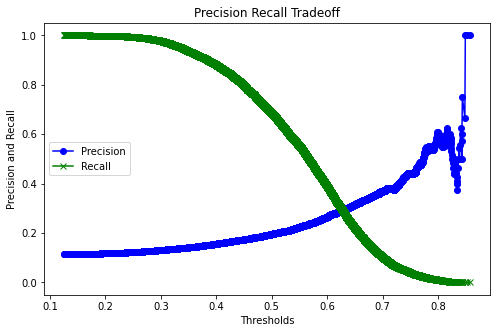

In [ ]:
plt.figure(figsize = (8, 5))
prec, rec, thresh = precision_recall_curve(y_train, y_train_prob)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'center left')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Tradeoff')
plt.show()

Best Threshold=0.505370, G-Mean=0.661


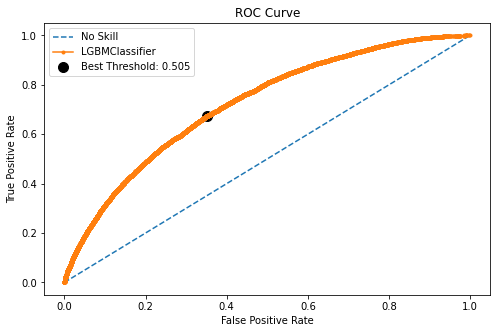

In [ ]:
plt.figure(figsize = (8, 5))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, y_train_prob)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_thresh = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_thresh, gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LGBMClassifier')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', alpha = 1, edgecolors = 'k', s = 100,
            label='Best Threshold: '+str(round(best_thresh, 3)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend(loc = 'best')
# show the plot
plt.show()

In [ ]:
acc = []
f1 = []
prec = []
rec = []
thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in thresh:
    pred = (y_train_prob >= i).astype(bool)
    f1.append(f1_score(y_train, pred))
    acc.append(accuracy_score(y_train, pred))
    prec.append(precision_score(y_train, pred))
    rec.append(recall_score(y_train, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

,Thresholds,Accuracy,F1,Precision,Recall
0,0.10,0.114704,0.205591,0.114573,1.000000
1,0.15,0.120752,0.206692,0.115259,0.999872
2,0.20,0.142033,0.210482,0.117643,0.998330
3,0.25,0.185963,0.218445,0.122720,0.993063
4,0.30,0.255559,0.231176,0.131098,0.977004
5,0.35,0.342595,0.246025,0.141619,0.936280
6,0.40,0.442435,0.265861,0.156542,0.881295
7,0.45,0.544408,0.285800,0.174180,0.795735
8,0.50,0.641349,0.304390,0.195670,0.684995
9,0.55,0.730033,0.319534,0.224627,0.553314


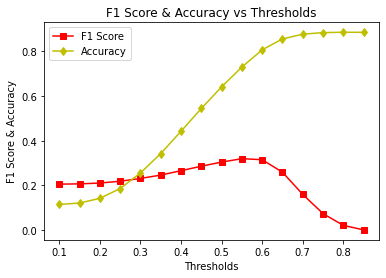

In [ ]:
plt.plot(thresh, f1, marker = 's', c = 'r', label = 'F1 Score')
plt.plot(thresh, acc, marker = 'd', c = 'y', label = 'Accuracy')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score & Accuracy')
plt.title('F1 Score & Accuracy vs Thresholds')
plt.legend(loc = 'best')
plt.show()

In [ ]:
y_train_pred = (y_train_prob >= best_thresh).astype(bool)
y_test_pred = (y_test_prob >= best_thresh).astype(bool)
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Train Accuracy Score: 0.6518859733035071
Train Confusion Matrix:
 [[39051 21114]
 [ 2540  5244]] 

Train F1 Score: 0.30718762814129225
Train Precision Score: 0.19895287958115182
Train Recall Score: 0.6736896197327852
Train ROC_AUC Score: 0.7226472406859212

Test Accuracy Score: 0.6383709350640431
Test Confusion Matrix:
 [[16596  9189]
 [ 1342  1994]] 

Test F1 Score: 0.27467456436393695
Test Precision Score: 0.17830635786461593
Test Recall Score: 0.5977218225419664
Test ROC_AUC Score: 0.6672355251342846


### Different Data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/PGPDSE/Capstone/CSV Files/Diabetes_Preprocessed.csv')
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,preceding_year_visits,number_diab_meds,number_changes,insulin_treatment
0,Caucasian,0,5,Not Available,Not Available,Referral,1,41,0,1,0,0,0,Diabetes,Not Required,Not Required,1,None,None,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,no_med
1,Caucasian,0,15,Emergency,Discharged to home,Emergency,3,59,0,18,0,0,0,"Endocrine, Nutritional, Metabolic, Immunity",Diabetes,"Endocrine, Nutritional, Metabolic, Immunity",9,None,None,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,1,-2,-2,-2,-2,-2,1,1,0,0,1,1,insulin_only
2,AfricanAmerican,0,25,Emergency,Discharged to home,Emergency,2,11,5,13,2,0,1,"Pregnancy, Childbirth",Diabetes,External causes of injury,6,None,None,-2,-2,-2,-2,-2,-2,0,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,0,1,0,3,1,0,other_meds
3,Caucasian,1,35,Emergency,Discharged to home,Emergency,2,44,1,16,0,0,0,Infectious and Parasitic,Diabetes,Circulatory,7,None,None,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,1,-2,-2,-2,-2,-2,1,1,0,0,1,1,insulin_only
4,Caucasian,1,45,Emergency,Discharged to home,Emergency,1,51,0,8,0,0,0,Neoplasms,Neoplasms,Diabetes,5,None,None,-2,-2,-2,-2,-2,-2,0,-2,-2,-2,-2,-2,-2,-2,-2,0,-2,-2,-2,-2,-2,1,1,0,0,2,0,insulin_combo


In [ ]:
df.shape

(97070, 47)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97070 entries, 0 to 97069
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      97070 non-null  object
 1   gender                    97070 non-null  int64 
 2   age                       97070 non-null  int64 
 3   admission_type_id         97070 non-null  object
 4   discharge_disposition_id  97070 non-null  object
 5   admission_source_id       97070 non-null  object
 6   time_in_hospital          97070 non-null  int64 
 7   num_lab_procedures        97070 non-null  int64 
 8   num_procedures            97070 non-null  int64 
 9   num_medications           97070 non-null  int64 
 10  number_outpatient         97070 non-null  int64 
 11  number_emergency          97070 non-null  int64 
 12  number_inpatient          97070 non-null  int64 
 13  diag_1                    97070 non-null  object
 14  diag_2                

In [ ]:
for i in df.columns:
    print(i, df[i].unique(), '\n')

race ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic'] 

gender [0 1] 

age [ 5 15 25 35 45 55 65 75 85 95] 

admission_type_id ['Not Available' 'Emergency' 'Elective'] 

discharge_disposition_id ['Not Available' 'Discharged to home'
 'Transferred to another medical facility'
 'Discharged to home with home health service' 'Left AMA'
 'Still patient/referred to this institution'] 

admission_source_id ['Referral' 'Emergency' 'Transferred from another health care facility'
 'Not Available'] 

time_in_hospital [ 1  3  2  4  5 13 12  9  7 10 11  6  8 14] 

num_lab_procedures [ 41  59  11  44  51  31  70  73  68  33  47  62  60  55  49  75  45  29
  35  42  19  64  25  53  52  87  27  37  28  36  48  10   2  65  67  40
  58  57  32  83  34  39  69  38  22  96  46  72  78  56  61  88  66  43
  50   1  18  82  54   9  63  24  71  77  81  76  90  93   3 103  13  80
  85  16  15  12  30  23  17  21  79  26  95  97  84  14  74 105  86  98
  20   5   6  94   8 102   7  89  91  92   4 101

In [ ]:
df = df.drop(['metformin-rosiglitazone', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'], 1)

In [ ]:
X = df.drop(['readmitted'], 1)
y = df['readmitted']
X_dum = pd.get_dummies(X, drop_first = True)
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size = 0.3, random_state = 0, stratify = y)

In [ ]:
lgb = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1)
lgb.fit(X_train, y_train)
sorted(zip(lgb.feature_importances_, X_train.columns), reverse = True)

[(393, 'num_lab_procedures'),
 (366, 'num_medications'),
 (220, 'time_in_hospital'),
 (174, 'age'),
 (141, 'num_procedures'),
 (115, 'number_diagnoses'),
 (103, 'number_inpatient'),
 (99, 'preceding_year_visits'),
 (68, 'insulin'),
 (60, 'number_emergency'),
 (57, 'number_outpatient'),
 (45, 'metformin'),
 (45, 'diag_1_Circulatory'),
 (44, 'gender'),
 (41, 'glipizide'),
 (37, 'diag_1_Respiratory'),
 (36, 'number_changes'),
 (35, 'race_Caucasian'),
 (34, 'diag_3_Circulatory'),
 (32, 'number_diab_meds'),
 (30, 'diabetesMed'),
 (28, 'A1Cresult_None'),
 (27, 'insulin_treatment_insulin_only'),
 (27, 'diag_2_Circulatory'),
 (25, 'diag_2_Diabetes'),
 (24, 'diag_2_Neoplasms'),
 (24, 'diag_1_Diabetes'),
 (24, 'change'),
 (21, 'diag_2_Respiratory'),
 (20, 'diag_3_Genitourinary'),
 (19, 'diag_3_Diabetes'),
 (18, 'max_glu_serum_None'),
 (18, 'diag_1_Pregnancy, Childbirth'),
 (18, 'diag_1_Injury and Poisoning'),
 (17, 'insulin_treatment_other_meds'),
 (17, 'glyburide'),
 (17, 'diag_3_Nervous'),
 (1

In [ ]:
lgb_cw = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
lgb_cw.fit(X_train, y_train)
sorted(zip(lgb_cw.feature_importances_, X_train.columns), reverse = True)

[(410, 'num_lab_procedures'),
 (350, 'num_medications'),
 (212, 'time_in_hospital'),
 (165, 'age'),
 (135, 'num_procedures'),
 (109, 'number_diagnoses'),
 (106, 'number_inpatient'),
 (83, 'preceding_year_visits'),
 (65, 'insulin'),
 (64, 'number_outpatient'),
 (58, 'number_diab_meds'),
 (45, 'number_emergency'),
 (42, 'metformin'),
 (39, 'diag_1_Circulatory'),
 (37, 'number_changes'),
 (37, 'glipizide'),
 (36, 'gender'),
 (36, 'diag_1_Respiratory'),
 (35, 'race_Caucasian'),
 (31, 'diag_3_Circulatory'),
 (29, 'insulin_treatment_insulin_only'),
 (28, 'diag_1_Genitourinary'),
 (28, 'diabetesMed'),
 (25, 'A1Cresult_None'),
 (24, 'diag_2_Respiratory'),
 (23, 'diag_2_Diabetes'),
 (23, 'diag_1_Diabetes'),
 (22, 'diag_2_Neoplasms'),
 (22, 'change'),
 (22, 'A1Cresult_Norm'),
 (22, 'A1Cresult_>8'),
 (21, 'glyburide'),
 (20, 'diag_2_Skin and Subcutaneous Tissue'),
 (20, 'diag_1_Injury and Poisoning'),
 (19, 'diag_3_Endocrine, Nutritional, Metabolic, Immunity'),
 (19, 'diag_1_External causes of in

In [ ]:
lgb_fi_df = pd.DataFrame({'Features' : X_train.columns, 'Importances without CW' : lgb.feature_importances_,
                          'Importances with CW' : lgb_cw.feature_importances_})
lgb_fi_df

,Features,Importances without CW,Importances with CW
0,gender,44,36
1,age,174,165
2,time_in_hospital,220,212
3,num_lab_procedures,393,410
4,num_procedures,141,135
...,...,...,...
99,A1Cresult_None,28,25
100,A1Cresult_Norm,16,22
101,insulin_treatment_insulin_only,27,29
102,insulin_treatment_no_med,6,1


In [ ]:
imp = lgb_fi_df[lgb_fi_df['Importances without CW'] >= 0]['Features']
print("Number of features:", len(imp))
lgb1 = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1)
lgb1.fit(X_train[imp], y_train)
pred = lgb1.predict(X_test[imp])
prob = lgb1.predict_proba(X_test[imp])[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

Number of features: 104
[[25757    28]
 [ 3285    51]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     25785
           1       0.65      0.02      0.03      3336

    accuracy                           0.89     29121
   macro avg       0.77      0.51      0.48     29121
weighted avg       0.86      0.89      0.84     29121

ROC_AUC: 0.6539475226101841


In [ ]:
imp = lgb_fi_df[lgb_fi_df['Importances without CW'] >= 19]['Features']
print("Number of features:", len(imp))
lgb1 = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1)
lgb1.fit(X_train[imp], y_train)
pred = lgb1.predict(X_test[imp])
prob = lgb1.predict_proba(X_test[imp])[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

Number of features: 31
[[25738    47]
 [ 3292    44]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     25785
           1       0.48      0.01      0.03      3336

    accuracy                           0.89     29121
   macro avg       0.69      0.51      0.48     29121
weighted avg       0.84      0.89      0.83     29121

ROC_AUC: 0.6522861582752414


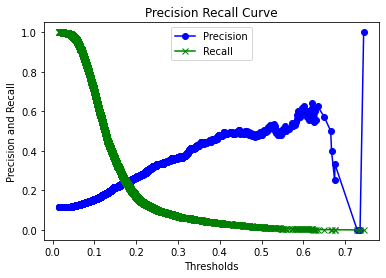

In [ ]:
prec, rec, thresh = precision_recall_curve(y_test, prob)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'best')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Curve')
plt.show()

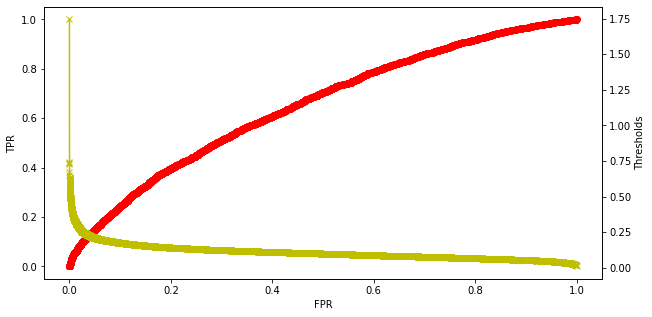

In [ ]:
fpr, tpr, thresh = roc_curve(y_test, prob)
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(fpr, tpr, marker = 'o', c = 'r')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr, thresh, marker = 'x', c = 'y')
ax1.set_ylabel('Thresholds')
plt.show()

In [ ]:
acc = []
f1 = []
prec = []
rec = []
thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in thresh:
    pred = (prob >= i).astype(bool)
    f1.append(f1_score(y_test, pred))
    acc.append(accuracy_score(y_test, pred))
    prec.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Thresholds,Accuracy,F1,Precision,Recall
0,0.10,0.525360,0.252784,0.154201,0.700839
1,0.15,0.778339,0.267725,0.215368,0.353717
2,0.20,0.850692,0.205990,0.263551,0.169065
3,0.25,0.873390,0.154164,0.328446,0.100719
4,0.30,0.879640,0.115569,0.365231,0.068645
5,0.35,0.883555,0.088196,0.428198,0.049161
6,0.40,0.885134,0.065381,0.481481,0.035072
7,0.45,0.885340,0.044088,0.490446,0.023082
8,0.50,0.885340,0.025678,0.483516,0.013189
9,0.55,0.885443,0.013601,0.500000,0.006894


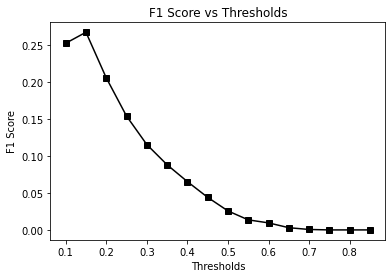

In [ ]:
plt.plot(thresh, f1, marker = 's', c = 'k')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Thresholds')
plt.show()

In [ ]:
imp = lgb_fi_df[lgb_fi_df['Importances with CW'] >= 0]['Features']
print("Number of features:", len(imp))
lgb1 = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
lgb1.fit(X_train[imp], y_train)
pred = lgb1.predict(X_test[imp])
prob = lgb1.predict_proba(X_test[imp])[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

Number of features: 104
[[17085  8700]
 [ 1492  1844]]
              precision    recall  f1-score   support

           0       0.92      0.66      0.77     25785
           1       0.17      0.55      0.27      3336

    accuracy                           0.65     29121
   macro avg       0.55      0.61      0.52     29121
weighted avg       0.83      0.65      0.71     29121

ROC_AUC: 0.6497606801121057


In [ ]:
imp = lgb_fi_df[lgb_fi_df['Importances with CW'] >= 22]['Features']
print("Number of features:", len(imp))
lgb1 = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)
lgb1.fit(X_train[imp], y_train)
pred = lgb1.predict(X_test[imp])
prob = lgb1.predict_proba(X_test[imp])[:, 1]
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC_AUC:", roc_auc_score(y_test, prob))

Number of features: 31
[[16912  8873]
 [ 1485  1851]]
              precision    recall  f1-score   support

           0       0.92      0.66      0.77     25785
           1       0.17      0.55      0.26      3336

    accuracy                           0.64     29121
   macro avg       0.55      0.61      0.51     29121
weighted avg       0.83      0.64      0.71     29121

ROC_AUC: 0.6465425972194903


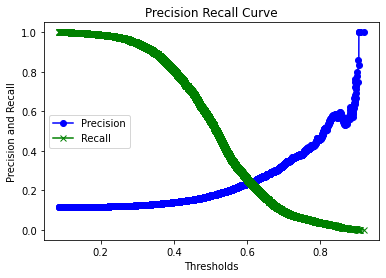

In [ ]:
prec, rec, thresh = precision_recall_curve(y_test, prob)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'best')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Curve')
plt.show()

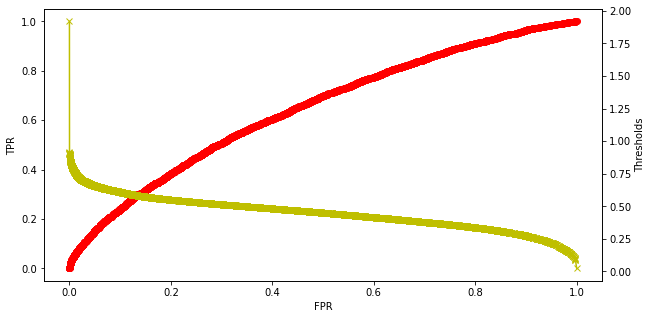

In [ ]:
fpr, tpr, thresh = roc_curve(y_test, prob)
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(fpr, tpr, marker = 'o', c = 'r')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax1 = ax.twinx()
ax1.plot(fpr, thresh, marker = 'x', c = 'y')
ax1.set_ylabel('Thresholds')
plt.show()

In [ ]:
acc = []
f1 = []
prec = []
rec = []
thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in thresh:
    pred = (prob >= i).astype(bool)
    f1.append(f1_score(y_test, pred))
    acc.append(accuracy_score(y_test, pred))
    prec.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

,Thresholds,Accuracy,F1,Precision,Recall
0,0.10,0.117956,0.206095,0.114894,0.999400
1,0.15,0.129288,0.207575,0.115868,0.995504
2,0.20,0.148244,0.209963,0.117463,0.988010
3,0.25,0.179183,0.213743,0.120044,0.973921
4,0.30,0.228598,0.219349,0.124057,0.946043
5,0.35,0.304763,0.227606,0.130399,0.894185
6,0.40,0.410185,0.238787,0.140108,0.807554
7,0.45,0.522235,0.250821,0.152872,0.698141
8,0.50,0.644312,0.263300,0.172604,0.554856
9,0.55,0.752962,0.261548,0.198876,0.381894


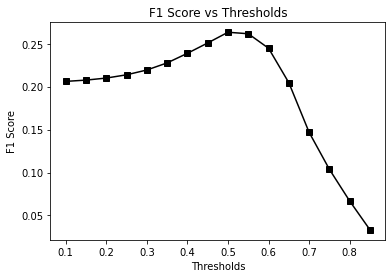

In [ ]:
plt.plot(thresh, f1, marker = 's', c = 'k')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Thresholds')
plt.show()